In [1]:
##### some basic modules
import os
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

##### Image-related modules
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import cv2 

##### keras module
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
##### Import custom function

from data_preprocessing import rgb_lab_transformation, feature_label_generation, data_generation
from visualization import visualize_validation_image
from GAN_model import GAN

## 1. Uploading and Preprocessing Dataset

##### Uploading

In [3]:
size_row = 128
size_col = 128

dir_name = '..' # name of directory where image data is located

In [4]:
train_image, test_image, train_label, test_label = data_generation(dir_name = dir_name,
                                                                   image_size = (size_row, size_col),
                                                                   single_character = 'melon-chan') 
                                                                   # for training only one character, need to specify the character name

1/1


In [5]:
train_feature = train_image.reshape(train_image.shape[0], size_row, size_col, 1) 
test_feature = test_image.reshape(test_image.shape[0], size_row, size_col, 1)

x_feature = np.concatenate([train_feature, test_feature])
x_label = np.concatenate([train_label, test_label])

## 2. Defining and Fitting the Model

##### Define the model

In [6]:
latent_dim = 1000

In [7]:
gan = GAN(input_shape = (size_row, size_col), latent_dim = latent_dim)

In [8]:
optimizer = Adam(0.0001, 0.5)

# Build and compile the discriminator
discriminator = gan.build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 33, 33, 64)        0         
__________

In [9]:
# Build the generator
generator = gan.build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 16, 16, 384)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       442496    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
__________

In [10]:
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img_l_input = Input(shape=(size_row, size_col,1))

img_ab = generator([z, img_l_input])

# For the combined model we will only train the generator
discriminator.trainable = False

In [11]:
# The discriminator takes generated images as input and determines validity
valid = discriminator(img_ab)

In [12]:
# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model([z, img_l_input], valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [13]:
combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 128, 128, 3)  8740818     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            464193      model_2[1][0]                    
Total para

##### Combine three gray image and conver to lab image

In [14]:
epochs = 5000
batch_size = 32

In [15]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
image_valid = cv2.resize(image_valid, (size_row, size_col))

img_gray = rgb2gray(image_valid).reshape(size_row, size_col, 1)
img_gray3 = np.concatenate([img_gray]*3, axis = 2) # concatenating three gray images so that it can have 3 channels
img_lab3 = rgb2lab(img_gray3) # convert concatenated image to lab

valid_input = img_lab3[:,:,0].reshape(1, size_row, size_col, 1)/128

##### Fitting

In [16]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [17]:
g_losses = []
d_losses = []
img_colorized = []

for epoch in range(epochs):

    ##### Train Discriminator

    # Select a random batch-size number of images
    idx = np.random.randint(0, x_feature.shape[0], batch_size)
    imgs = x_feature[idx]
    label = x_label[idx] 
    
    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict([noise, imgs])

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(np.concatenate([imgs,label], axis = -1), valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    ##### Train Generator
    
    noise_com = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch([noise, imgs], valid)
    g_losses.append(g_loss)
    d_losses.append(d_loss[0])
    
    ##### Visualize image

    if epoch % 250 == 0:
    
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        zero_noise = np.zeros(latent_dim).reshape(1,latent_dim)
        gen_imgs = generator.predict([zero_noise, valid_input])
        image_indiv_ab = gen_imgs[0,:,:,1:].reshape(size_row, size_col,2)
        image_indiv = np.concatenate([img_lab3[:,:,:1]/128, image_indiv_ab], axis = 2)

        img_colorized.append(lab2rgb(image_indiv.astype('float64')*128)) 
        # note that we multiply 128 since we previously scaled from -128 to 128 (LAB) to -1 to 1


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.510695, acc.: 32.81%] [G loss: 0.533070]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 642 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


250 [D loss: 0.261446, acc.: 87.50%] [G loss: 1.646747]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 223 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


500 [D loss: 0.159167, acc.: 95.31%] [G loss: 2.223294]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


750 [D loss: 0.207558, acc.: 90.62%] [G loss: 4.520574]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1000 [D loss: 0.112980, acc.: 96.88%] [G loss: 3.986361]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1250 [D loss: 0.056350, acc.: 98.44%] [G loss: 2.960273]
1500 [D loss: 0.026802, acc.: 100.00%] [G loss: 5.171188]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 5 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1750 [D loss: 0.022982, acc.: 100.00%] [G loss: 5.133464]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


2000 [D loss: 0.013526, acc.: 100.00%] [G loss: 5.425250]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


2250 [D loss: 0.015792, acc.: 100.00%] [G loss: 5.669089]
2500 [D loss: 0.022386, acc.: 100.00%] [G loss: 4.842685]
2750 [D loss: 0.037534, acc.: 100.00%] [G loss: 4.994274]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 10 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


3000 [D loss: 0.021230, acc.: 100.00%] [G loss: 4.292880]
3250 [D loss: 0.008426, acc.: 100.00%] [G loss: 5.471400]
3500 [D loss: 0.006752, acc.: 100.00%] [G loss: 5.987763]
3750 [D loss: 0.055084, acc.: 98.44%] [G loss: 3.678832]
4000 [D loss: 0.014727, acc.: 100.00%] [G loss: 5.687539]
4250 [D loss: 0.004637, acc.: 100.00%] [G loss: 5.941535]
4500 [D loss: 0.016938, acc.: 100.00%] [G loss: 6.155239]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


4750 [D loss: 0.010766, acc.: 100.00%] [G loss: 6.741459]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 12 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


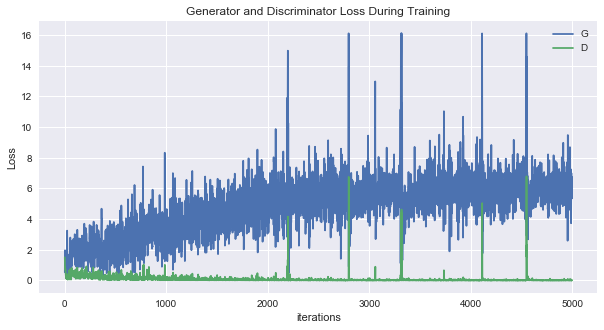

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

##### Visualization

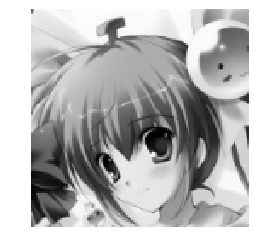

In [19]:
input_val = img_gray.copy()
plt.imshow(input_val.reshape(size_row, size_col), cmap = 'gray')
plt.axis('off')
plt.show()

In [20]:
grid_row = 4
grid_col = 5

In [21]:
g_row = []
i = 0

for r in range(grid_row):
    
    g_column = []
    
    for c in range(grid_col):
        g_column.append(img_colorized[i])
        i += 1
        
    g_column = np.concatenate(g_column, axis = 1)
    g_row.append(g_column)

g_row = np.concatenate(g_row)

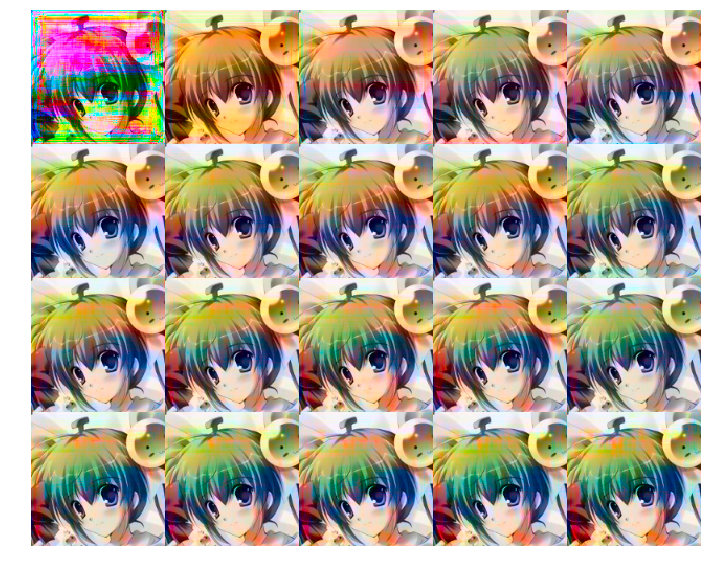

In [22]:
plt.figure(figsize = (12,12))
plt.axis('off')
plt.imshow(g_row)

##### Colorization using DIfferent Noise Values

In [23]:
def custom_noise(latent_dim = 1000, sequence_num = 5, interval = 5, interval_order = [-2,-1,0,1,2]):

    seq_length = int(latent_dim / sequence_num)

    noise_vec = []

    for s in range(sequence_num):

        for i in interval_order: # total length = sequence_num * len(interval_order)

            noise_original = np.zeros((1, latent_dim))
            noise_original[:, (s)*seq_length:(s+1)*seq_length] = noise_original[:, (s)*seq_length:(s+1)*seq_length] + interval*i

            noise_vec.append(noise_original)

    return np.concatenate(noise_vec, axis = 0)

In [24]:
gen_imgs = generator.predict([custom_noise(), np.concatenate([valid_input]*25, axis = 0)])

In [25]:
r, c = 5, 5

image_col = []
i = 0

for col_num in range(c):

    image_row = []

    for row_num in range(r):

        image_indiv_ab = gen_imgs[i,:,:,1:].reshape(size_row, size_col,2)
        image_indiv = np.concatenate([img_lab3[:,:,:1]/128, image_indiv_ab], axis = 2)
        image_row.append(image_indiv.astype('float64'))
        i += 1

    image_row = np.concatenate(image_row)
    image_col.append(image_row)

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 620 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


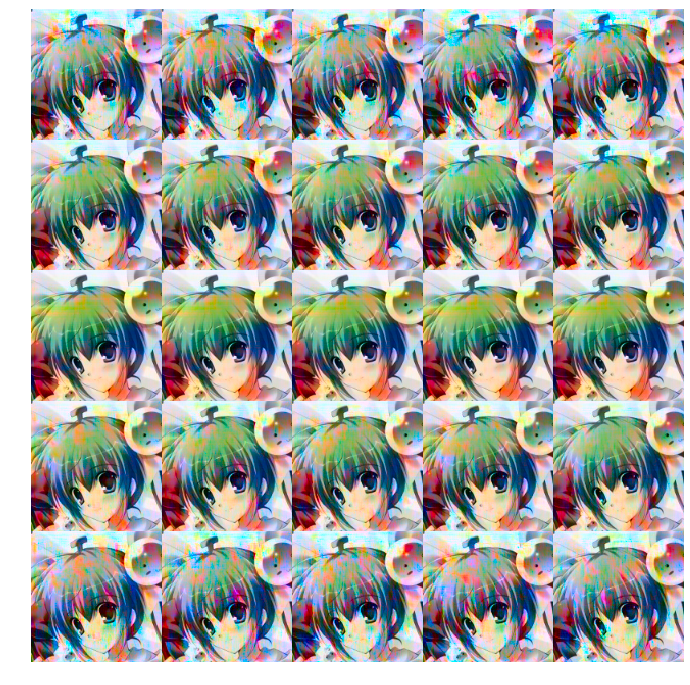

In [26]:
plt.figure(figsize = (12,12))
plt.axis('off')
plt.imshow(lab2rgb(np.concatenate(image_col, axis = 1)*128))
plt.show()

##### Test with different image (same character)

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 112 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


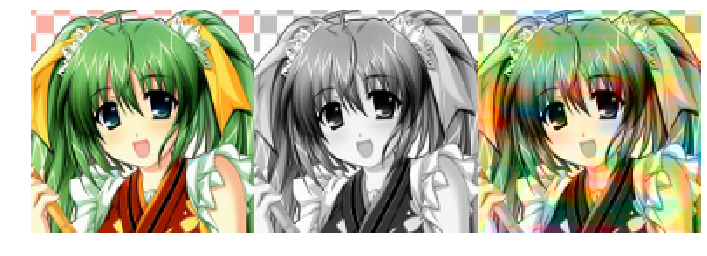

In [27]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
visualize_validation_image(image_valid, generator, image_size = (size_row, size_col), latent_dim = 1000)

##### Test with Different Character

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 47 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


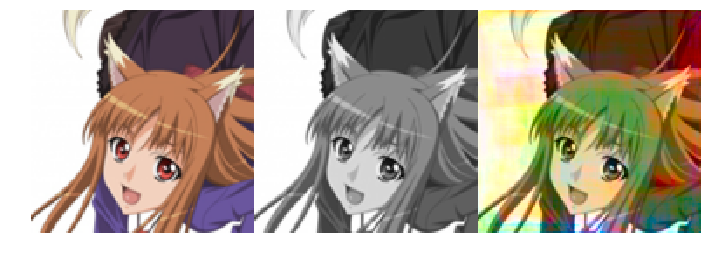

In [28]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
visualize_validation_image(image_valid, generator, image_size = (size_row, size_col), latent_dim = 1000)